In [103]:
import torch
import random
import numpy as np
import matplotlib.pyplot as plt
import pickle
from tqdm import tqdm
import time
import pandas as pd
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
from torch import Tensor
#Using newest versions of all libraries

# Simple CNN cluster image classifier

This notebook provides a framework for classifying cluster images from the ATLAS Open Data dataset [ATLAS simulated samples collection for jet reconstruction training](http://opendata.cern.ch/record/15010).
The dataset contains Monte-Carlo simulated samples corresponding to SM hadronic physics processes. As of now (03.20.2022) only the first part of the dataset is used for this analysis. Using the python script in this project 'cut_njets_root.py', the root file is converted into separate files containing 2D histograms. For each number of Truth Jets a category is created, and all the events associated with that number of Truth Jets is placed in the same file for easy access. Data processing is an essential part of any ML process, and this process of creating images is both naive and not necessarily physically motivated. Future work will focus on creating better images, but for now the simple histograms are used for a 'proof-of-concept' version of the code.

In [104]:
#variables controlled by the user. Change these to fit your specific needs.
VAL_PCT = 0.2 #The percentage of the data to be used as the validation set.
N_EVENTS = 10000 #Number of events to process for each class. If higher than the available number of events an exception will be raised.
MODEL_NAME = "jet_nr-" + str(int(time.time())) #A unique name for the model
print(MODEL_NAME)
N_JETS = [2, 3] #A list containing the classes of n number of jets we wish to train for
OUTPUTS = len(N_JETS) #The number of output nodes in the net, equal to the number of classes
DATAPATH = "../data/histograms/" #The path to the folder containing the histogram files
RES = 80 #resolution
FILENAMES = [f"jets_part1_njets_{n}_{RES}x{RES}.pkl" for n in N_JETS] #Filenames should match this format
CUDA = torch.device('cuda') #Change this to cpu if cuda is not abailable

jet_nr-1643894707


In [105]:
class CalorimeterDataset(Dataset):
    #Creates tuple object used in the dataloader
    def __init__(self, images, labels):
            self.img_labels = labels
            self.images = images
            
    def __len__(self):
        return len(self.img_labels)
    
    def __getitem__(self, idx):
        image = self.images[idx]
        label = self.img_labels[idx]
        return image, label

def load_pickle_file(path:str, file_name:str):
    #Outputs the pickle file as a numpy array
    return np.array(pickle.load(open(path + file_name, 'rb') ))

def label_maker(njets:list, nevents:int):
    #Creates labels for the classes. The first class gets value [1, 0, .., 0], the next [0, 1, ..., 0] etc
    a = torch.zeros(nevents*len(njets), len(njets), dtype=torch.int)
    for i in range(len(njets)):
        for j in range(nevents):
            a[nevents*i + j][i] = 1
    return a

def normalize(AA, batchsize:int):
    #Normalises the histograms to ensure that the net gets inputs in the range (0, 1)
    AA = AA.view(AA.size(0), -1)
    AA -= AA.min(1, keepdim=True)[0]
    AA /= AA.max(1, keepdim=True)[0]
    AA = AA.view(batchsize, RES, RES, 1)
    return AA

def load_data(input_files, data_path):
    #Loads the data files and outputs CalorimeterDaataset objects
    val_size = int(N_EVENTS*VAL_PCT)
    train_size = int(N_EVENTS*(1-VAL_PCT))
    
    data = [load_pickle_file(data_path, input_files[i]) for i in range(len(input_files))]
    for i in range(len(data)):
        item = data[i]
        np.random.shuffle(item)
        data[i] = Tensor(item)
    
    Cal_train = torch.cat([data[i][0:train_size] for i in range(len(input_files))]).unsqueeze(3).float().to(CUDA)
    Cal_train = normalize(Cal_train, len(Cal_train))
    labels_train = label_maker(N_JETS, train_size).float().to(CUDA)
    print(len(Cal_train), len(labels_train)) #Double check that these match

    Cal_test = torch.cat([data[i][(train_size+1):(train_size+1+val_size)] for i in range(len(input_files))]).unsqueeze(3).float().to(CUDA)
    Cal_test = normalize(Cal_test, len(Cal_test))
    labels_test = label_maker(N_JETS, val_size).float().to(CUDA)
    print(len(Cal_test), len(labels_test)) #Double check that these match
    
    train_dataset = CalorimeterDataset(Cal_train, labels_train)
    test_dataset = CalorimeterDataset(Cal_test, labels_test)
    
    return train_dataset, test_dataset

### Load the data

Start by loading the data and then taking a look at it.

In [106]:
#load data
traindata, testdata = load_data(FILENAMES, DATAPATH)

16000 16000
4000 4000


[[[1.0, 0.0], [1.0, 0.0], [1.0, 0.0]], [[0.0, 1.0], [0.0, 1.0], [0.0, 1.0]]]


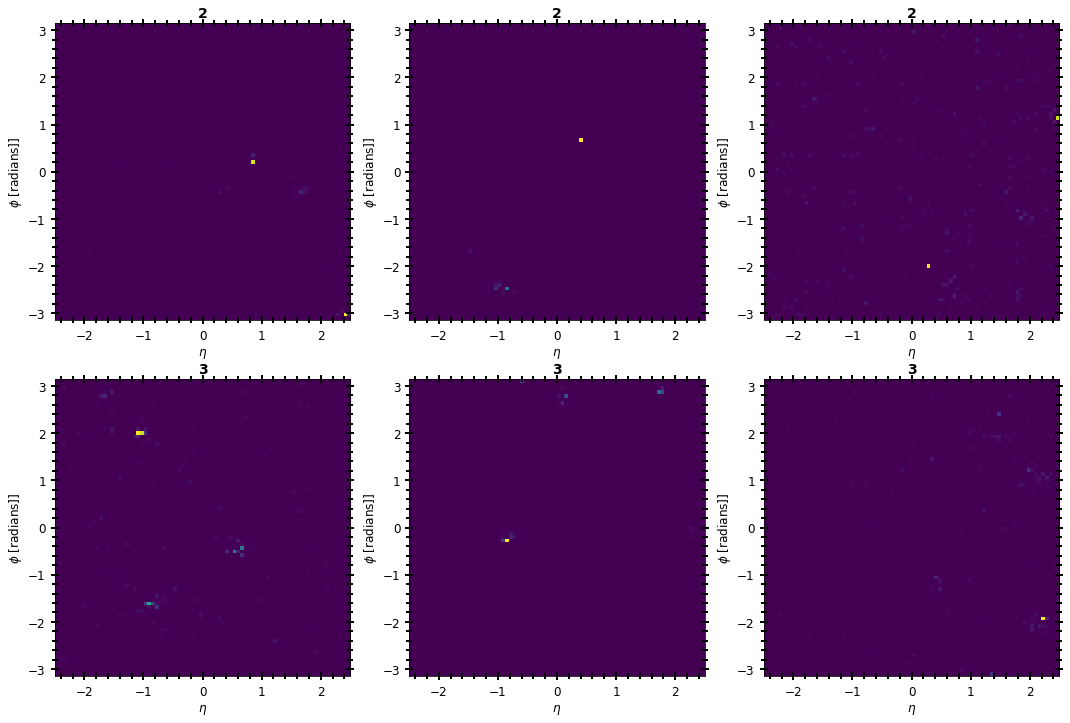

In [107]:
def cal_image_plot(ax, n_jets):
    ax.set_ylabel(r"$\phi$ [radians]]", fontsize=12)
    ax.set_xlabel(r"$\eta$", fontsize=12)
    ax.set_title(str(n_jets), fontsize=14,weight="bold")
    ax.tick_params(which="both", direction="inout", top=True, right=True, labelsize=12, pad=5, length=4, width=2)
    ax.tick_params(which="major", length=8)
    ax.tick_params(which="minor", length=6)
    ax.minorticks_on()

img_per_row = 3
k = [[i]*img_per_row for i in range(OUTPUTS)]
for i in range(len(k)):
    row = k[i]
    row = [item*(N_EVENTS*(VAL_PCT)) for item in row]
    row = [int(item + np.random.randint(1, high = 100)) for item in row]
    k[i] = row

images = [testdata.images[item].cpu() for item in k]
labels = [testdata.img_labels[item].cpu() for item in k]
labels = [label.tolist() for label in labels]
print(labels) #Double check that this matches the expected values

fig, axs = plt.subplots(nrows = OUTPUTS, ncols = img_per_row, figsize = (img_per_row*6, OUTPUTS*6))
for i in range (len(k)):
    for j in range(img_per_row):
        cal_image_plot(axs[i][j], int(N_JETS[i]))
        axs[i][j].imshow(images[i][j], extent=[-2.5, 2.5, -np.pi, np.pi], aspect='auto')


### Create the NN and start training

We will now create the neural network architecture and the functions for training and testing our network. This is a convoluted neural network CNN. 


In [108]:
class ConvNet(nn.Module):
    #This code is heavily inspired by/copied from this tutorial; https://pythonprogramming.net/introduction-deep-learning-neural-network-pytorch/
    def __init__(self):
        super().__init__() # just run the init of parent class (nn.Module)
        self.conv1 = nn.Conv2d(1, 32, 5) # input is 1 image, 32 output channels, 5x5 kernel / window
        self.conv2 = nn.Conv2d(32, 64, 5) # input is 32, bc the first layer output 32. Then we say the output will be 64 channels, 5x5 kernel / window
        self.conv3 = nn.Conv2d(64, 128, 5)

        x = torch.randn(RES,RES).view(-1,1,RES,RES) #Dummy image used in to_linear func
        self._to_linear = None
        self.convs(x)

        self.fc1 = nn.Linear(self._to_linear, 512) #flattening.
        self.fc2 = nn.Linear(512, OUTPUTS) # 512 in, OUTPUTS out -> number of classes

    def convs(self, x:Tensor):
        # max pooling over 2x2
        x = F.max_pool2d(F.relu(self.conv1(x)), (2, 2))
        x = F.max_pool2d(F.relu(self.conv2(x)), (2, 2))
        x = F.max_pool2d(F.relu(self.conv3(x)), (2, 2))

        if self._to_linear is None:
            self._to_linear = x[0].shape[0]*x[0].shape[1]*x[0].shape[2] #calculates the output that needs to be flattened
        return x

    def forward(self, x:Tensor):
        x = self.convs(x)
        x = x.view(-1, self._to_linear)  # .view is reshape ... this flattens X before 
        x = F.relu(self.fc1(x))
        x = self.fc2(x) # bc this is our output layer. No activation here.
        return F.softmax(x, dim=1)


In [109]:
#This code is heavily inspired by/copied from this tutorial; https://pythonprogramming.net/introduction-deep-learning-neural-network-pytorch/
def fwd_pass(net, X:Tensor, y:Tensor, train=False):
    #Checks to see if we are testing or training, as we do NOT want to update weights for testing.
    if train:
        net.zero_grad()
    #Calculates the accuracy and loss
    outputs = net(X.view(-1, 1, RES, RES).to(CUDA))
    matches = [torch.argmax(i) == torch.argmax(j) for i, j in zip(outputs, y)]
    acc = matches.count(True)/len(matches)
    loss = loss_function(outputs, y.to(CUDA)) # loss_function(outputs, y)
    #If we are training we will apply backpropogation and update the weights, stepping towards lower loss.
    if train:
        loss.backward()
        optimizer.step()
    return acc, loss

def test(net, data, size:str = 32):
    #Returns accuracy and loss on validation data
    dataset = DataLoader(data, size, shuffle=True) #shuffle data and choose batch size
    X, y = next(iter(dataset)) #get a random batch
    val_acc, val_loss = fwd_pass(net, X, y)
    return val_acc, val_loss
    
def predict(net, data):
    #Returns the predictions (as class number values)
    dataset = DataLoader(data, 1, shuffle=True) #shuffle data and choose batch size
    prediction = torch.zeros(len(dataset))
    truth = torch.zeros(len(dataset))
    i = 0
    for data in tqdm(dataset):
        X, y = data
        output = net(X.view(-1, 1, 80, 80).to(CUDA))
        prediction[i] = torch.argmax(output)
        truth[i] = torch.argmax(y)
        i = i +1
    return truth, prediction
        

def train(net, traindata, testdata, size:str, epochs:str):
    #Main training loop. Creates a pandas dataframe and stores information about the training process in it.
    dataset = DataLoader(traindata, size, shuffle=True)
    df_labels = ["Loss", "Accuracy", "Validation loss", "Validation accuracy", "Epoch", "Iteration"]
    df_data = [[0], [0], [0], [0], [0], [0]]
    df = pd.DataFrame(dict(zip(df_labels, df_data)))
    i = 0
    for epoch in tqdm(range(epochs)):
        for data in dataset:
            i = i+1
            X, y = data
            acc, loss = fwd_pass(net, X, y, train=True)
            if i % 10 == 0: #Computes validation metrics only for 1/10 of the iterations
                val_acc, val_loss = test(net, testdata, size=size)
                df_data = [float(loss), acc, float(val_loss), val_acc, epoch, i]
                new_df = pd.DataFrame(dict(zip(df_labels, df_data)), index=[0])
                df = pd.concat([df, new_df], ignore_index=True)
    return df

In [110]:
#create NN and test that nothing major is wrong.
net = ConvNet()
net.to(device = CUDA)
testimage, testlabel = traindata.images[0], traindata.img_labels[0]
print(net(testimage.view(-1, 1, RES, RES).to(CUDA)))

tensor([[0.4969, 0.5031]], device='cuda:0', grad_fn=<SoftmaxBackward0>)


In [111]:
#Set learning rate, optimizer, loss function and start training
optimizer = optim.Adam(net.parameters(), lr=0.0001)
loss_function = nn.CrossEntropyLoss()
training_results = train(net, traindata, testdata, 100, 40)

100%|██████████| 40/40 [01:47<00:00,  2.68s/it]


### Analyzing our model
Let's take a look at the learning metrics collected in our dataframe. High accuracy on training data and low accuracy on validation implies overtraining. Low accuracy in both categories mean that the network is not learning. Next look at the loss. Loss should go down if the model is learning. If the validation loss starts going up we have overtrained. 

<AxesSubplot:xlabel='Iteration'>

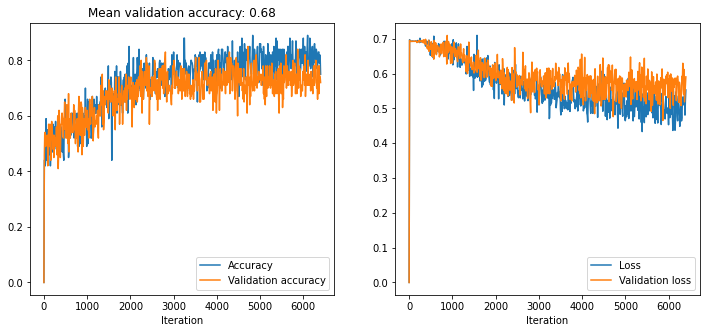

In [112]:
fig, axs = plt.subplots(nrows = 1, ncols = 2, figsize = (12, 5))
training_results.plot("Iteration", ["Accuracy", "Validation accuracy"], ax=axs[0], 
                    title="Mean validation accuracy: " + str(round(training_results["Validation accuracy"].mean(), 2)))
training_results.plot("Iteration", ["Loss", "Validation loss"], ax=axs[1])

To further analyse our model we can check how the predictions compare to the true values. This can highlight which classes we are having trouble with.

In [113]:
truth, preds = predict(net, testdata)
confusion = pd.DataFrame(dict(zip(["Truth", "Predictions"], [truth, preds])))
print(preds[:50])
print(truth[:50])

100%|██████████| 4000/4000 [00:03<00:00, 1278.60it/s]

tensor([1., 1., 0., 0., 1., 0., 1., 1., 0., 0., 0., 0., 1., 0., 0., 1., 0., 1.,
        1., 0., 0., 1., 0., 1., 0., 0., 1., 1., 0., 0., 1., 0., 0., 0., 1., 0.,
        1., 1., 0., 0., 1., 0., 1., 0., 0., 0., 0., 1., 1., 1.])
tensor([1., 1., 0., 0., 1., 0., 1., 1., 0., 1., 1., 0., 1., 0., 1., 1., 0., 1.,
        1., 1., 1., 1., 0., 1., 0., 0., 1., 1., 0., 1., 1., 0., 1., 1., 1., 0.,
        0., 1., 0., 0., 1., 0., 1., 1., 0., 0., 0., 1., 0., 1.])


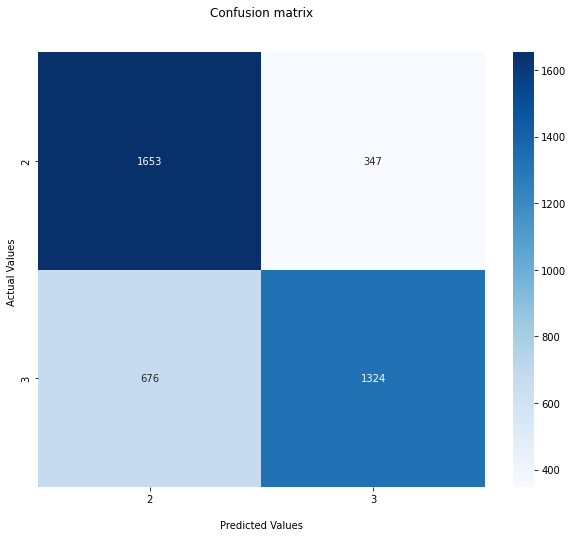

In [114]:
from sklearn.metrics import confusion_matrix
import seaborn as sn

fig, ax = plt.subplots(figsize = (10, 8))

#Generate the confusion matrix
cf_matrix = confusion_matrix(confusion["Truth"], confusion["Predictions"])
ax = sn.heatmap(cf_matrix, annot=True, cmap='Blues', fmt='g')

ax.set_title('Confusion matrix\n\n');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');

## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(N_JETS)
ax.yaxis.set_ticklabels(N_JETS)

## Display the visualization of the Confusion Matrix.
plt.show()

(-0.5, 1.5)

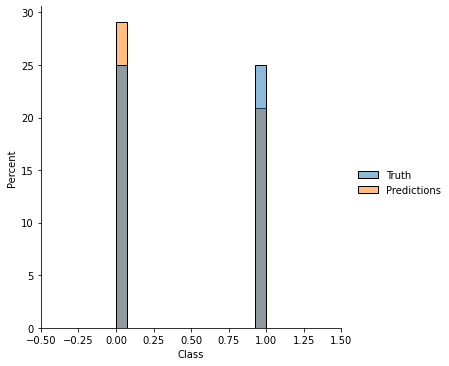

In [115]:
import seaborn as sn
#fig, ax = plt.subplots(figsize = (10, 8))
sn.displot(confusion, stat="percent")
#sn.displot(confusion, x="Truth", color="blue")
plt.xlabel("Class")
plt.xlim(-0.5, OUTPUTS -0.5)